In [1]:
from pymdp import utils, agent
import numpy as np
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import matplotlib.pyplot as plt


In [3]:
qs_hist = [np.array([np.array([1.e+00, 1.e-16, 1.e-16, 1.e-16, 1.e-16, 1.e-16, 1.e-16, 1.e-16, 1.e-16])]),
            np.array([np.array([1.e-16, 1.e-16, 1.e-16, 1.e+00, 2.e-16, 2.e-16, 3.e-16, 3.e-16, 3.e-16])]),
            np.array([np.array([1.e-16, 2.e-16, 3.e-16, 1.e-16, 1.e+00, 5.e-16, 1.e-16, 4.e-16, 7.e-16])]),
            np.array([np.array([1.0e-16, 1.0e-16, 1.0e-16, 2.0e-16, 3.0e-16, 4.0e-16, 3.0e-16, 1.0e+00, 1.3e-15])])] # Shape: (4, 9)

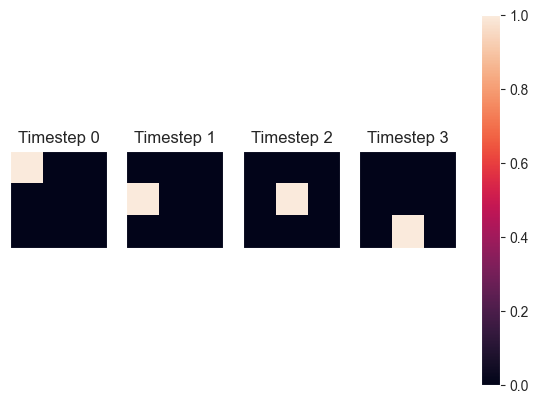

In [14]:
num_timesteps = len(qs_hist)
num_timesteps

fig, axes = plt.subplots(1, num_timesteps, sharey=True)
cax = None
for t in range(num_timesteps):
    state_grid = qs_hist[t][0].reshape((3, 3))
    ax = axes[t]
    cax = ax.imshow(state_grid, vmin=0, vmax=1)
    ax.set_title(f'Timestep {t}')
    ax.set_xticks([])  # Remove x ticks
    ax.set_yticks([])  # Remove y ticks
fig.colorbar(cax, ax=axes, orientation='vertical', fraction=0.05)
plt.show()

In [2]:
env_map = generate_random_map(size=4)
print(env_map)

['SFFH', 'FFHH', 'FFFH', 'FFFG']


In [3]:
env_map[3][1]

'F'

In [4]:
s_loc = [i for i in range(16)]
S = [s_loc]

o_loc = [i for i in range(16)]
o_tile_type = ['ice', 'hole', 'goal']
O = [o_loc, o_tile_type]

u_mov = ['left', 'right', 'up', 'down']
U = [u_mov]

env_rows = 4
env_cols = 4

In [71]:
def create_a(observations, states):
    num_obs = [len(o_factor) for o_factor in observations]
    num_states = [len(state_factor) for state_factor in states]
    
    A = utils.initialize_empty_A(num_obs=num_obs, num_states=num_states)
    return A

In [72]:
A = create_a(O, S)

In [74]:
for a in A:
    print(a.shape)

(16, 16)
(3, 16)


In [76]:
# filling out location obs given location state
A[0][:, :] = np.eye(A[0].shape[0])

In [94]:
A[1][0,:].shape[0]
len(env_map)

4

In [92]:
# filling out tile type obs (row) given location state (col)
for i in range(env_rows):
    for j in range(env_cols):
        curr_pos = (i * env_cols) + j
        
        if env_map[i][j] == 'G':
            A[1][2, curr_pos] = 1.0
        elif env_map[i][j] == 'H':
            A[1][1, curr_pos] = 1.0
        else:
            A[1][0, curr_pos] = 1.0

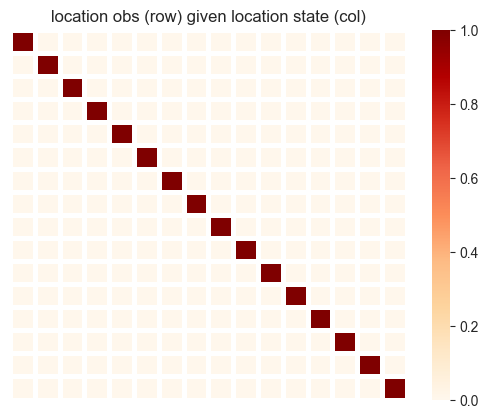

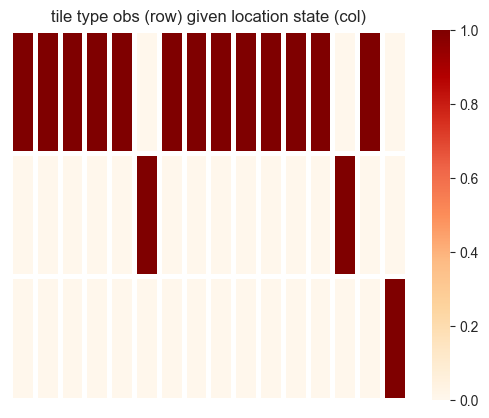

In [93]:
utils.plot_likelihood(A[0][:, :], title='location obs (row) given location state (col)')
utils.plot_likelihood(A[1][:, :], title='tile type obs (row) given location state (col)')

In [5]:
def create_B(states, actions):
    num_states = [len(state_factor) for state_factor in states]
    num_controls = [len(control_factor) for control_factor in actions]
    empty_B = utils.initialize_empty_B(num_states, num_controls)
    return empty_B

In [6]:
B = create_B(S, U)

In [7]:
for b in B:
    print(b.shape) # structure is b[loc | loc, action] for the transition model
    # meaning we index like b[new loc, given prev loc, prev action]

(16, 16, 4)


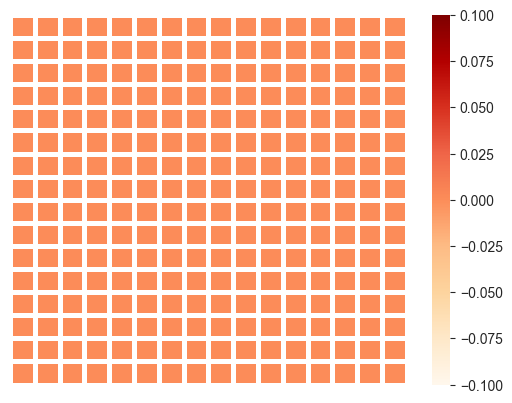

In [8]:
utils.plot_likelihood(B[0][:,:,0])

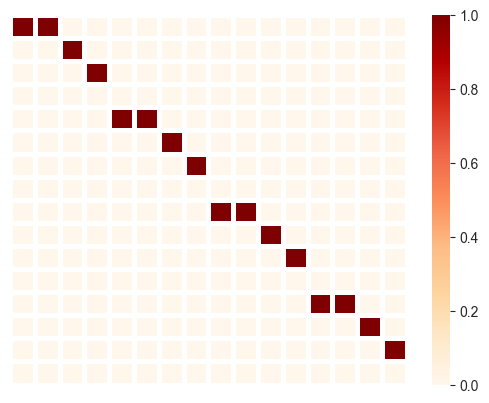

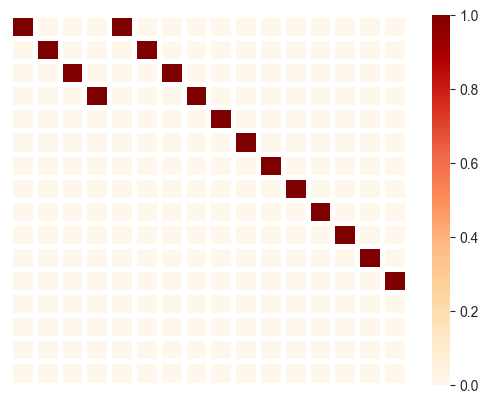

In [12]:
for i in range(4):
    for j in range(4):
        curr_pos = (i * 4) + j

        # going up
        if i == 0:
            B[0][curr_pos, curr_pos, 2] = 1.0
        if i < 4 - 1:
            # print(curr_pos, i, j)
            B[0][curr_pos, curr_pos+4, 2] = 1.0

        # going left
        if j == 0:
            B[0][curr_pos, curr_pos:curr_pos+2, 0] = 1.0
        elif j == 4 - 1:
            pass
            # B[0][curr_pos, curr_pos-1, 0] = 1.0
        else:
            B[0][curr_pos, curr_pos+1, 0] = 1.0

# going right looks like a flip of left horizontally and then vertically
B[0][:,:,1] = np.fliplr(np.flipud(B[0][:,:,0]))

# going down is up flipped over horizontal and vertical
B[0][:, :, 3] = np.fliplr(np.flipud(B[0][:, :, 2]))
            
utils.plot_likelihood(B[0][:, :, 0])
utils.plot_likelihood(B[0][:, :, 2])